In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from torchvision import datasets, models
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from random import randrange

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from scipy.misc import imresize

# supress scipy imresize deprecation warning
import warnings
warnings.filterwarnings('ignore')

import copy
import time
import shutil
import os

%matplotlib inline

In [151]:
class retinaDataset(Dataset):
    def __init__(self, dataset_dir, labels_csv, n_samples=0, all_classes=False):
        self.dir = dataset_dir
        
        self.df = pd.read_csv(labels_csv)
        
        self._balance_samples(n_samples, all_classes)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        
        if isinstance(i, slice):
            start = 0 if not i.start else i.start
            stop = len(self) if not i.stop else i.stop
            step = 1 if not i.step else i.step
            
            return [self[i] for i in range(start, stop, step)]
        else:
        
            sample = np.load(os.path.join(self.dir, self.df.iloc[i]['image'] + ".npy"))
            label  = self.df.iloc[i]['level']
            
            sample = sample.transpose((2, 0, 1))
            
            sample = torch.from_numpy(sample)
            
            return [sample, label]
    
    def split_validation(self, split):
        int_split = int(np.round(self.df.shape[0] * split))
        
        validation = copy.deepcopy(self)
        validation.df = validation.df[int_split:]
        
        self.df = self.df[:int_split]
        
        return validation
    
    def _balance_samples(self, n, all_classes):
        if n > 0:
            if all_classes:
                class_n = int(n / self.num_classes)

                level_0_df = self.df.query('level == 0').sample(class_n)
                level_1_df = self.df.query('level == 1').sample(class_n)
                level_2_df = self.df.query('level == 2').sample(class_n)
                level_3_df = self.df.query('level == 3').sample(class_n)
                level_4_df = self.df.query('level == 4').sample(class_n)

                self.df = pd.concat([level_0_df, level_1_df, level_2_df, level_3_df, level_4_df])
                # Shuffle and reset index
                self.df = self.df.sample(frac=1).reset_index(drop=True)
                
            else:
                self.num_classes = 2
                class_n = int(n / 2)
                
                level_0_df = self.df.query('level == 0').sample(class_n)
                level_1_df = self.df.query('level == 1 or level == 2 or level == 3 or level == 4').sample(class_n)
                
                # Replace all labels for 1
                level_1_df.loc[level_1_df.level > 0, 'level'] = 1
            
                self.df = pd.concat([level_0_df, level_1_df])
                # Shuffle and reset index
                self.df = self.df.sample(frac=1).reset_index(drop=True)
    

In [152]:
dataset_dir = "/data/datasets/diabeticRetinopathy/"
train_dir = dataset_dir + "conv_resnet_152/"
labels_csv = "/data/datasets/diabeticRetinopathy/train/trainLabels.csv"

In [153]:
split = 0.8

n_samples = 14000
train_dataset = retinaDataset(train_dir, labels_csv, n_samples, False)
val_dataset = train_dataset.split_validation(split)

In [154]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=10, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=10, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

In [155]:
print("{} items for train and {} for validation".format(len(train_dataset), len(val_dataset)))

data, label = train_loader.sampler.data_source[0]
print(data.max(), data.min())

11200 items for train and 2800 for validation
9.352638244628906 0.0


In [185]:
class FineTuneModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTuneModel, self).__init__()
        
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
        self.big_dense = nn.Linear(in_features=2048, out_features=32)
        self.little_dense = nn.Linear(in_features=32, out_features=2)

    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.big_dense(x)
        x = self.little_dense(x)
        return x

In [260]:
class FineTuneModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTuneModel, self).__init__()
        
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
        self.dense1 = nn.Linear(in_features=2048, out_features=1024)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dense2 = nn.Linear(in_features=1024, out_features=512)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dense3 = nn.Linear(in_features=512, out_features=256)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout()
        self.dense4 = nn.Linear(in_features=256, out_features=num_classes)
        self.log_softmax = nn.LogSoftmax()
        
        # self.frac_max_pool = nn.FractionalMaxPool2d(kernel_size=7, output_size=(7, 7))
        
    
    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dense1(x)
        x = self.leaky_relu1(x)
        x = self.dense2(x)
        x = self.leaky_relu2(x)
        x = self.dropout1(x)
        x = self.dense3(x)
        x = self.leaky_relu3(x)
        x = self.dense4(x)
        x = self.log_softmax(x)
        
        return x

In [261]:
model = FineTuneModel(2)
# model.features = torch.nn.DataParallel(model.features)
model.cuda()

FineTuneModel (
  (avg_pool): AvgPool2d (size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
  (dense1): Linear (2048 -> 1024)
  (leaky_relu1): LeakyReLU (0.01)
  (dense2): Linear (1024 -> 512)
  (leaky_relu2): LeakyReLU (0.01)
  (dense3): Linear (512 -> 256)
  (leaky_relu3): LeakyReLU (0.01)
  (dropout1): Dropout (p = 0.5)
  (dense4): Linear (256 -> 2)
  (log_softmax): LogSoftmax ()
)

In [262]:
# Parameters
start_epoch = 0
epochs = 100
batch_size = 10
weigth_decay = 1e-4
learning_rate = 0.001
momentum = 0.9

In [263]:
import sys
import lib.pytorch_trainer as ptt

In [264]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()), # Only finetunable params
    learning_rate,
    momentum=momentum
)

cb_chkpt = ptt.ModelCheckpoint(
    'Models/checkpoint.pth',
    reset=True, 
    verbose=1
)

csv_logger = ptt.CSVLogger(
    './logging.csv'
)

scheduler = StepLR(optimizer, step_size=3, gamma=0.75)

In [265]:
training_parameters = {
    'model':         model, 
    'criterion':     criterion, 
    'optimizer':     optimizer, 
    'lr_scheduler':  scheduler,
    'callbacks': [
        ptt.AccuracyMetric(),
        ptt.PlotCallback(),
        ptt.PrintCallback(),
        cb_chkpt
    ]
}
trainer = ptt.DeepNetTrainer(**training_parameters)

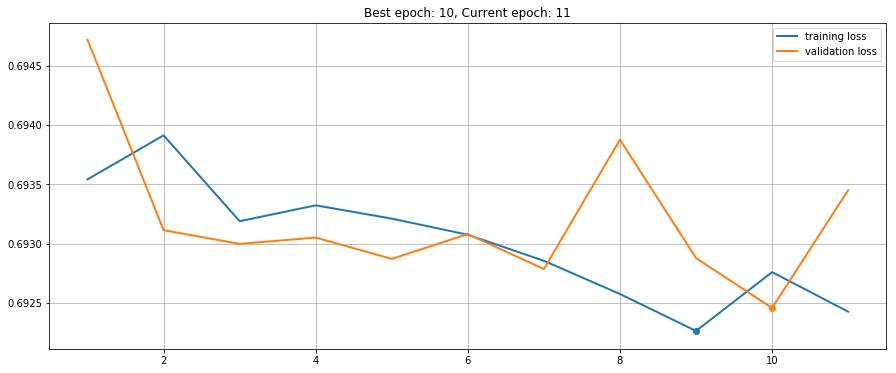

 11:   8.9s   T: 0.69243 0.51500   V: 0.69345 0.50429 


In [ ]:
trainer.fit_loader(epochs, train_loader, val_loader)

In [191]:
trainer.load_state('Models/checkpoint.pth')

In [192]:
# x_train, y_train = next(iter(train_loader))
# print(y_train)

trainer.evaluate_loader(val_loader)


evaluate: 279/279 ok


{'losses': 0.675859848516328}

In [193]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

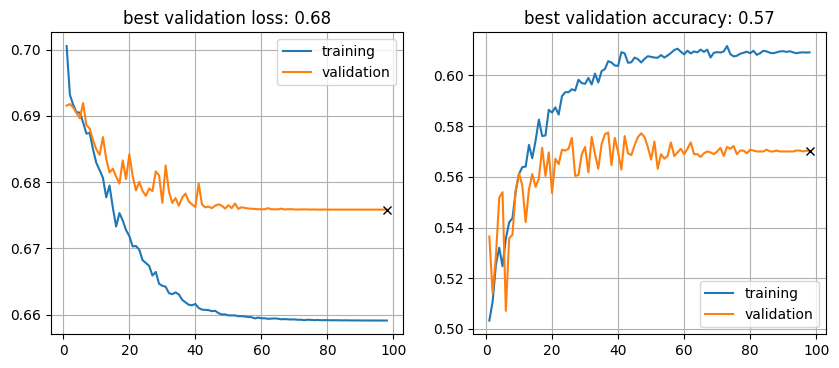

In [194]:
show_history(trainer)

In [66]:
model = models.resnet152(pretrained=True)
print(model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott